## Pipeline Steps

#### Pre-Step: Calibrate the camera to get the camera matrix and distortion coefficients
 
#### Pipeline
 1. Undistort the image
 2. Threshold the image using gradients and colors
 3. Apply a Perspective Transform to view the image from top-down
 4. Identify the lane lines
 5. Un-transform back to orginal perspective
 6. Draw lane information on original image

### Pre-Step: Calibrate the Camera

Before can begin developing the pipeline for decting lane lines, we need to account for the distortion in our camera. To do that, we need some information about the camera - we need to calibrate it.

By inspecting pictures of a chessboard pattern (predictable/known pattern) we can find the distoration coefficients and camera matrix that we need to undistort images.

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [26]:
ret, cMat, coefs, rvects, tvects = None, None, None, None, None

def calibrate_camera():
    im_paths = glob.glob('./camera_cal_images/calibration*.jpg')

    cb_shape = (9, 6)  # Corners we expect to be detected on the chessboard

    obj_points = []  # 3D points in real-world space
    img_points = []  # 2D points in the image

    for im_path in im_paths:
        img = mpimg.imread(im_path)

        obj_p = np.zeros((cb_shape[0]*cb_shape[1], 3), np.float32)
        coords = np.mgrid[0:cb_shape[0], 0:cb_shape[1]].T.reshape(-1, 2)  # x, y coords

        obj_p[:,:2] = coords

        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        found_all, corners = cv2.findChessboardCorners(gray, cb_shape, None)
        if found_all:
            obj_points.append(obj_p)
            img_points.append(corners)
            img = cv2.drawChessboardCorners(img, cb_shape, corners, found_all)
        else:
            print("Couldn't find all corners in image:", im_path)
    
    return cv2.calibrateCamera(obj_points, img_points, gray.shape, None, None)
    
ret, cMat, coefs, rvects, tvects = calibrate_camera()
print(coefs)

[[ -2.47539663e-01  -1.51847046e-02  -1.18700379e-03  -2.48437227e-05
   -3.05600547e-02]]


#### Helper Plotting Functions

In [140]:
def side_by_side_plot(im1, im2, im1_title=None, im2_title=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    f.tight_layout()
    ax1.imshow(im1)
    if im1_title: ax1.set_title(im1_title, fontsize=30)
    ax2.imshow(im2)
    if im2_title: ax2.set_title(im2_title, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

def big_plot(img):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.imshow(img)

### Step 1: Undistort Images

Now we should be able to undistort images. Let's give it a try.

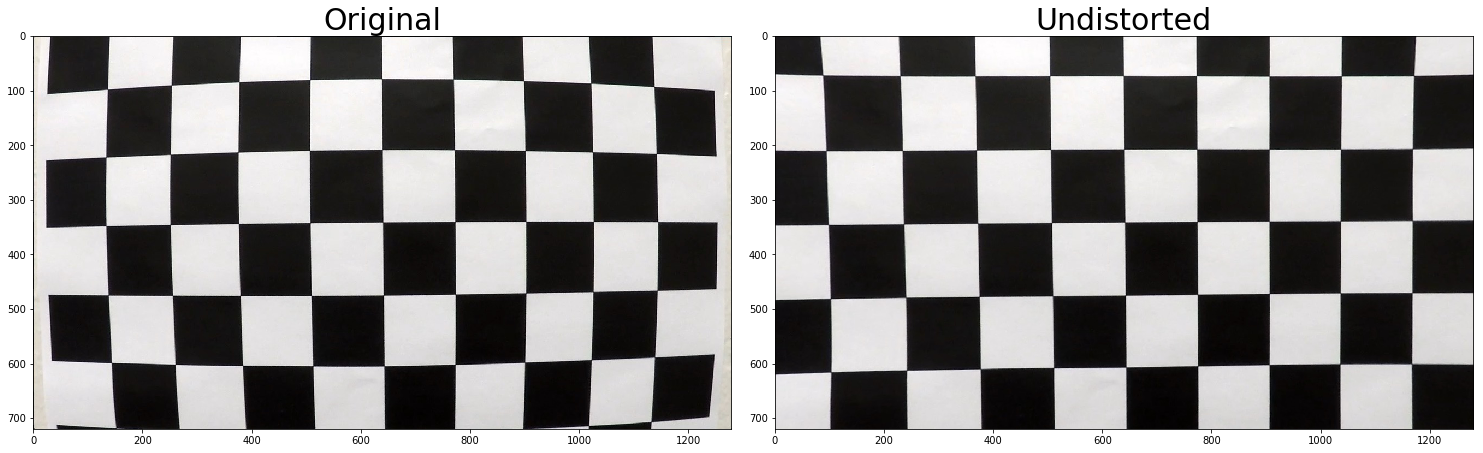

In [27]:
def undistort(img):
    if cMat is None: raise Exception('The camera needs to be calibrated first.')
    
    return cv2.undistort(img, cMat, coefs, None, cMat)
    
    
test_undistort = mpimg.imread('./camera_cal_images/not_enough_corners/calibration1.jpg')
undistorted = undistort(test_undistort)
side_by_side_plot(test_undistort, undistorted, 'Original', 'Undistorted')

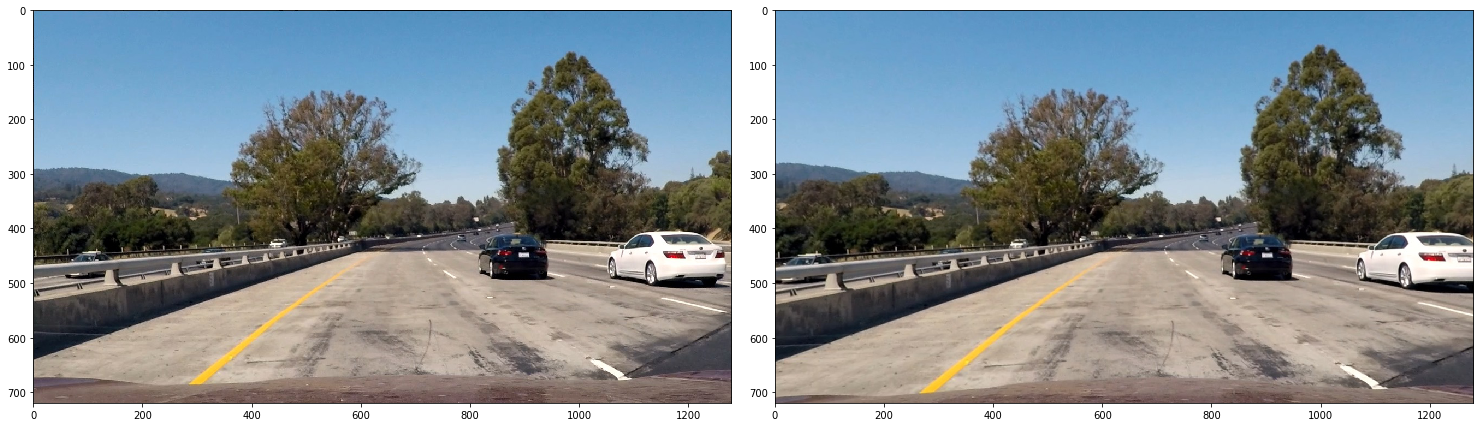

In [28]:
img = mpimg.imread('./test_images/test1.jpg')
undistorted = undistort(img)
side_by_side_plot(img, undistorted)

### Step 2: Thresholding

With a way to undistort our distorted camera images, we now need a good thresholding method that will utilize gradients and colors to detect the lane lines in the image.

Let's create a thresholding function.

In [104]:
def get_sobel_bin(img):
    ''' "img" should be 1-channel '''
    
    sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=9)  # x-direction gradient
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sobel_bin = np.zeros_like(scaled_sobel)
    sobel_bin[(scaled_sobel >= 20) & (scaled_sobel <= 100)] = 1
    
    return sobel_bin

def get_threshold(img, show=False):
    ''' "img" should be an undistorted image ''' 
    
    # Color-space conversions
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Sobel gradient binaries
    sobel_s_bin = get_sobel_bin(s_channel)
    sobel_gray_bin = get_sobel_bin(gray)
    
    sobel_comb_bin = np.zeros_like(sobel_s_bin)
    sobel_comb_bin[(sobel_s_bin == 1) | (sobel_gray_bin == 1)] = 1
    
    # HLS S-Channel binary
    s_bin = np.zeros_like(s_channel)
    s_bin[(s_channel >= 150) & (s_channel <= 255)] = 1
    
    # Combine the binaries
    comb_bin = np.zeros_like(sobel_comb_bin)
    comb_bin[(sobel_comb_bin == 1) | (s_bin == 1)] = 1
    
    gray_img = np.dstack((gray, gray, gray))
    sobel_s_img = np.dstack((sobel_s_bin, sobel_s_bin, sobel_s_bin))*255
    sobel_gray_img = np.dstack((sobel_gray_bin, sobel_gray_bin, sobel_gray_bin))*255
    sobel_comb_img = np.dstack((sobel_comb_bin, sobel_comb_bin, sobel_comb_bin))*255
    s_img = np.dstack((s_bin, s_bin, s_bin))*255
    comb_img = np.dstack((comb_bin, comb_bin, comb_bin))*255
    
    if show: side_by_side_plot(img, comb_img, 'Original', 'Thresholded')
    
    return comb_img

    
img = mpimg.imread('./test_images/test4.jpg')
threshold_img = get_threshold(img)

Great! Looks like the thresholding method works. We will combine this with the undistort method.

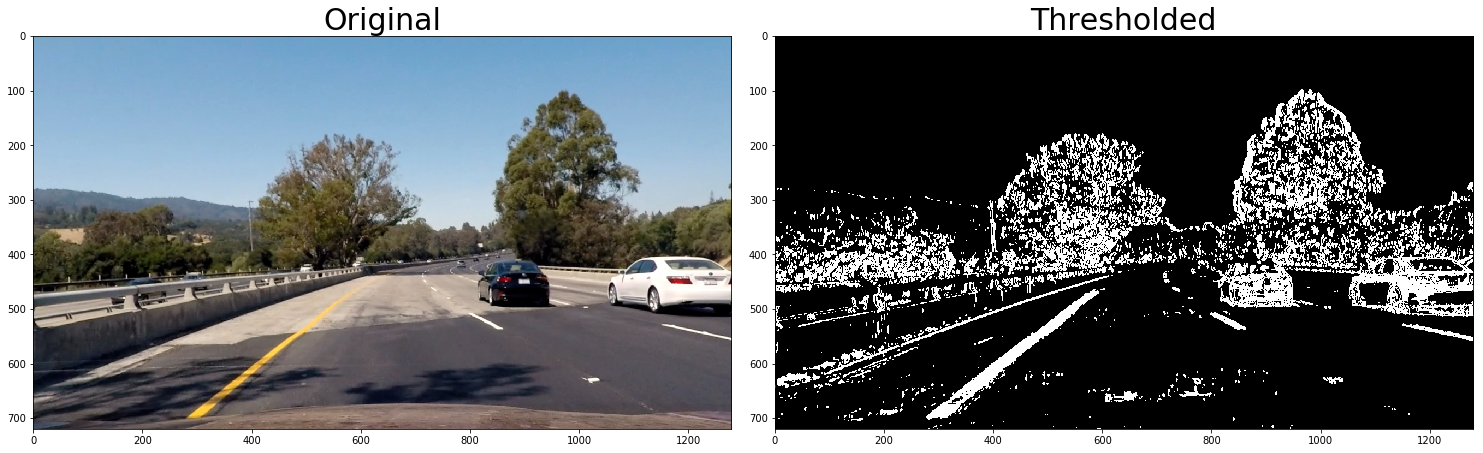

In [105]:
img = mpimg.imread('./test_images/test4.jpg')
undist = undistort(img)
threshold_img = get_threshold(undist, show=True)

### Step 3: Perspective Transform

Now that we can undistort images and threshold them to help isolate the important information, we need to further limit that information by looking only at the portion of the image we care about - the road.

To focus in on the road portion of the image we will shift our perspective to a top-down view of the road in front of the car.

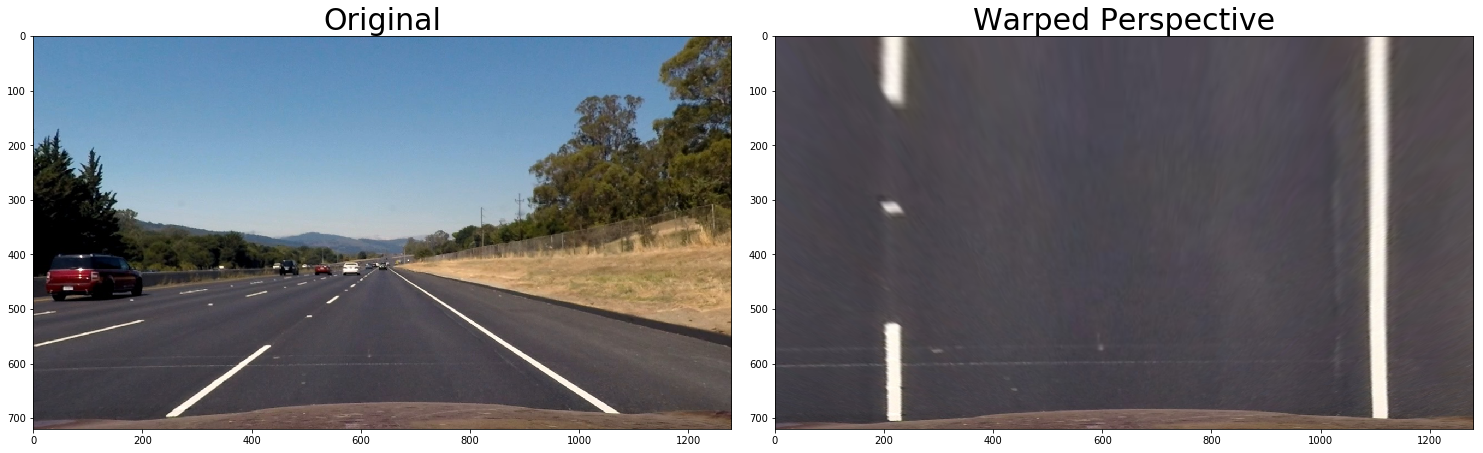

In [172]:
def warp_to_lines(img, show=False):
    ''' "img" should be an undistorted image. '''
    
    x_shape, y_shape = img.shape[1], img.shape[0]
    middle_x = x_shape//2
    top_y = 2*y_shape//3
    top_margin = 93
    bottom_margin = 450
    points = [
        (middle_x-top_margin, top_y),
        (middle_x+top_margin, top_y),
        (middle_x+bottom_margin, y_shape),
        (middle_x-bottom_margin, y_shape)
    ]

    '''
    # This shows the area we are warping to
    for i in range(len(points)):
        cv2.line(img, points[i-1], points[i], [255, 0, 0], 2)

    big_plot(img)
    '''

    src = np.float32(points)
    dst = np.float32([
        (middle_x-bottom_margin, 0),
        (middle_x+bottom_margin, 0),
        (middle_x+bottom_margin, y_shape),
        (middle_x-bottom_margin, y_shape)
    ])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (x_shape, y_shape), flags=cv2.INTER_LINEAR)
    
    if show: side_by_side_plot(img, warped, 'Original', 'Warped Perspective')
        
    return warped, M, Minv

img = mpimg.imread('./test_images/straight_lines2.jpg')
img = undistort(img)
warped, M, Minv = warp_to_lines(img, show=True)

Great! We now have a function that can warp our perspective from a forward-facing road image to a top-down roade image. The warped image will be perfect for isolating lane lines and measuring any curvature.

We will be applying this perspective warp to thresholded images.

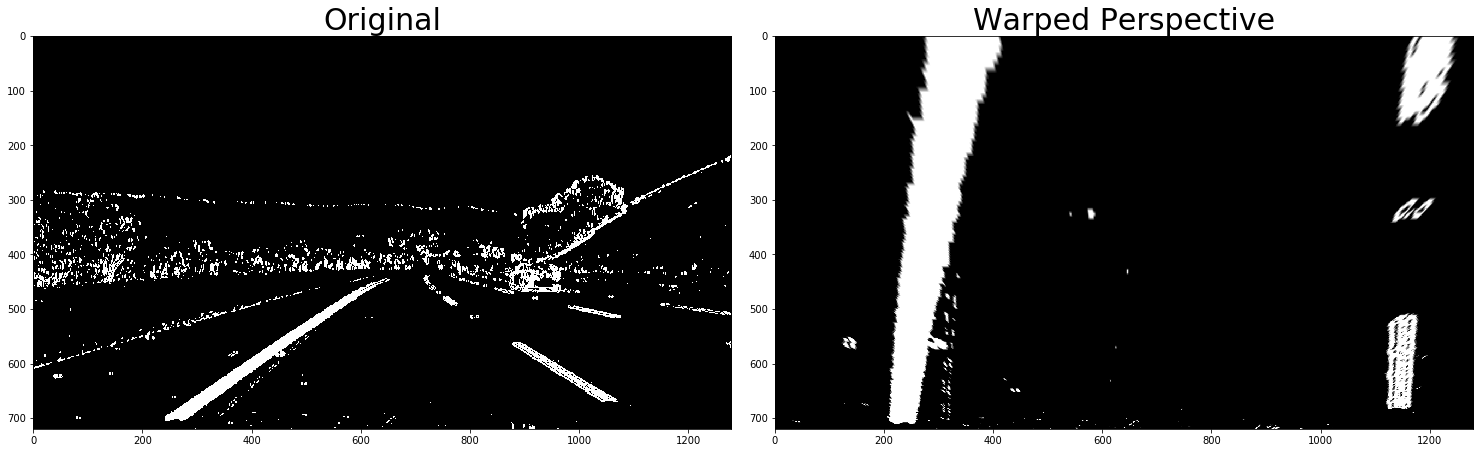

In [177]:
img = mpimg.imread('./test_images/test3.jpg')
undist = undistort(img)
thresholded = get_threshold(undist)
warped, M, Minv = warp_to_lines(thresholded, show=True)